In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!ls /kaggle/input/

In [1]:
import numpy as np
import pandas as pd
import os
import gc

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

import cv2
from tqdm import tqdm

In [2]:
x_train = []
y_train = []

df_train = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
df_train.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (64, 64)))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [01:55<00:00, 351.09it/s]


(40479, 64, 64, 3)
(40479, 17)


In [4]:
sample = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [5]:
df_test = sample[:40669]

df_test_extra = sample[40669:]

In [6]:
test = []
for f in tqdm(df_test.image_name.values, miniters=1000):
    img_test = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(f))
    test.append(cv2.resize(img_test, (64, 64)))
    
for f in tqdm(df_test_extra.image_name.values, miniters=1000):
    img_test2 = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(f))
    test.append(cv2.resize(img_test2, (64, 64)))
    
X_test = np.array(test, np.float16) / 255.

print(X_test.shape)

100%|██████████| 20522/20522 [01:14<00:00, 275.88it/s]


(61191, 64, 64, 3)


In [8]:
from keras.layers.normalization import BatchNormalization

In [9]:
model = Sequential()
model.add(BatchNormalization(input_shape=(64, 64, 3)))
model.add(Conv2D(8, 1, 1, padding='same', activation='relu'))
model.add(Conv2D(16, 2, 2,padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, 3, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, 3, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(128, 3, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(17, activation='sigmoid'))

In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
split = 35000

x_train, x_valid, y_train, y_valid = x_train[:split], x_train[split:], y_train[:split], y_train[split:]

In [12]:
history = model.fit(x_train, y_train,batch_size=128, epochs=100, verbose=1, 
          validation_data=(x_valid, y_valid), shuffle=True)


Epoch 1/100
274/274 [==============================] - 3s 12ms/step - loss: 0.2549 - accuracy: 0.1057 - val_loss: 0.2043 - val_accuracy: 0.0956
Epoch 2/100
274/274 [==============================] - 3s 10ms/step - loss: 0.1951 - accuracy: 0.1361 - val_loss: 0.1754 - val_accuracy: 0.1515
Epoch 3/100
274/274 [==============================] - 3s 10ms/step - loss: 0.1799 - accuracy: 0.1779 - val_loss: 0.1692 - val_accuracy: 0.1699
Epoch 4/100
274/274 [==============================] - 3s 10ms/step - loss: 0.1736 - accuracy: 0.1871 - val_loss: 0.1625 - val_accuracy: 0.1674
Epoch 5/100
274/274 [==============================] - 3s 10ms/step - loss: 0.1690 - accuracy: 0.2005 - val_loss: 0.1569 - val_accuracy: 0.1584
Epoch 6/100
274/274 [==============================] - 3s 11ms/step - loss: 0.1650 - accuracy: 0.1927 - val_loss: 0.1560 - val_accuracy: 0.1781
Epoch 7/100
274/274 [==============================] - 3s 11ms/step - loss: 0.1624 - accuracy: 0.1878 - val_loss: 0.1552 - val_accuracy:

274/274 [==============================] - 3s 10ms/step - loss: 0.1329 - accuracy: 0.1984 - val_loss: 0.1323 - val_accuracy: 0.1873
Epoch 58/100
274/274 [==============================] - 3s 10ms/step - loss: 0.1333 - accuracy: 0.1924 - val_loss: 0.1307 - val_accuracy: 0.1980
Epoch 59/100
274/274 [==============================] - 3s 10ms/step - loss: 0.1330 - accuracy: 0.1975 - val_loss: 0.1309 - val_accuracy: 0.1648
Epoch 60/100
274/274 [==============================] - 3s 10ms/step - loss: 0.1328 - accuracy: 0.1919 - val_loss: 0.1302 - val_accuracy: 0.1871
Epoch 61/100
274/274 [==============================] - 3s 10ms/step - loss: 0.1330 - accuracy: 0.1915 - val_loss: 0.1291 - val_accuracy: 0.2143
Epoch 62/100
274/274 [==============================] - 3s 11ms/step - loss: 0.1327 - accuracy: 0.1941 - val_loss: 0.1293 - val_accuracy: 0.1814
Epoch 63/100
274/274 [==============================] - 3s 10ms/step - loss: 0.1327 - accuracy: 0.1996 - val_loss: 0.1302 - val_accuracy: 0.182

Text(0.5, 1.0, 'Loss Curves - With Reularization')

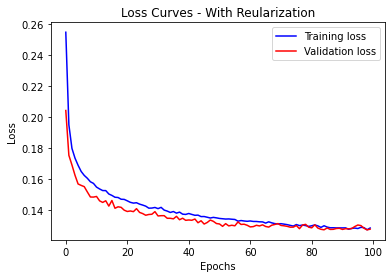

In [13]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], 'blue')
plt.plot(history.history['val_loss'], 'red')
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves - With Reularization')

In [14]:
import numpy as np
from sklearn.metrics import fbeta_score

def optimise_f2_thresholds(y, p, verbose=True, resolution=100):
    def mf(x):
        p2 = np.zeros_like(p)
        for i in range(17):
            p2[:, i] = (p[:, i] > x[i]).astype(np.int)
        score = fbeta_score(y, p2, beta=2, average='samples')
        return score

    x = [0.2]*17
    for i in range(17):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            i2 /= resolution
            x[i] = i2
            score = mf(x)
            if score > best_score:
                best_i2 = i2
                best_score = score
            
        x[i] = best_i2
        if verbose:
            print(i, best_i2, best_score)

    return x

In [15]:
from sklearn.metrics import fbeta_score

pred_valid = model.predict(x_valid, batch_size=128)

print(fbeta_score(y_valid, np.array(pred_valid) > 0.2, beta=2, average='samples'))

0.8847742153277119


In [17]:
p_valid = model.predict(x_valid, batch_size = 128, verbose=2)
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))
print("Optimizing prediction threshold")
print(optimise_f2_thresholds(y_valid, p_valid))

43/43 - 0s
0.8847742153277119
Optimizing prediction threshold
0 0.22 0.884832033594529
1 0.17 0.8851772176274965
2 0.06 0.885826361047426
3 0.09 0.8860307261740213
4 0.24 0.8862930308111143
5 0.23 0.8864071253595593
6 0.18 0.8866504718002182
7 0.22 0.8867378233032897
8 0.36 0.8878880069205004
9 0.21 0.8879237938186246
10 0.1 0.8883199199211116
11 0.05 0.8883199199211116
12 0.12 0.8883199199211116
13 0.04 0.8883199199211116
14 0.15 0.8883345246697945
15 0.19 0.8883345246697945
16 0.22 0.888426093965861
[0.22, 0.17, 0.06, 0.09, 0.24, 0.23, 0.18, 0.22, 0.36, 0.21, 0.1, 0.05, 0.12, 0.04, 0.15, 0.19, 0.22]


In [18]:
pred = model.predict(X_test, batch_size=128)

full_test = []
full_test.append(pred)

result = np.array(full_test[0])
result = pd.DataFrame(result, columns = labels)
result.head()

,clear,water,cloudy,artisinal_mine,agriculture,road,cultivation,haze,primary,habitation,partly_cloudy,slash_burn,blooming,blow_down,selective_logging,conventional_mine,bare_ground
0,0.998005,0.011120,6.991316e-09,5.529697e-14,0.007537,0.002048,0.002866,1.335887e-03,0.999996,0.000453,0.000366,4.522549e-07,0.003331,0.000318,0.000202,5.796627e-12,0.000074
1,0.997267,0.053253,4.366245e-08,2.038326e-09,0.066574,0.017048,0.040852,8.837673e-04,0.999983,0.004361,0.001073,2.028784e-04,0.022557,0.004906,0.006240,6.744332e-08,0.001805
2,0.000007,0.107056,3.313188e-05,3.615991e-07,0.099756,0.041175,0.024128,3.510264e-08,0.999922,0.003290,0.999958,6.938402e-05,0.000015,0.000087,0.000097,1.852067e-06,0.000364
3,0.998594,0.034929,1.289774e-08,2.012204e-10,0.023814,0.008648,0.013284,2.083995e-04,0.999993,0.002165,0.000637,2.237113e-05,0.016904,0.002304,0.003069,2.674759e-09,0.000604
4,0.017395,0.117930,3.693923e-01,2.887669e-05,0.149380,0.086211,0.029585,1.125835e-02,0.617373,0.015062,0.610748,1.335309e-04,0.000027,0.000018,0.000237,2.345747e-05,0.001737


In [19]:
# thres = [0.07, 0.17, 0.2, 0.04, 0.23, 0.33, 0.24, 0.22, 0.1, 0.19, 0.23, 0.24, 0.12, 0.14, 0.25, 0.26, 0.16]
thres2 = [0.22, 0.17, 0.06, 0.09, 0.24, 0.23, 0.18, 0.22, 0.36, 0.21, 0.1, 0.05, 0.12, 0.04, 0.15, 0.19, 0.22] 
prediction = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.loc[[i]]
    a = a.apply(lambda x: x > thres2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    prediction.append(' '.join(list(a.index)))

100%|██████████| 61191/61191 [02:21<00:00, 431.68it/s]


In [20]:
sample['tags'] = prediction
sample.head()

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,primary partly_cloudy
3,test_3,clear primary
4,test_4,cloudy primary partly_cloudy


In [39]:
sample.to_csv('submission_4.csv', index=False)

In [5]:
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

y_train = []
x_train = []

for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (64, 64)))
    y_train.append(targets)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

print(x_train.shape)
print(y_train.shape)

100%|██████████| 40479/40479 [01:58<00:00, 342.48it/s]


(40479, 64, 64, 3)
(40479, 17)


In [6]:
test = []
for f in tqdm(df_test.image_name.values, miniters=1000):
    img_test = cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(f))
    test.append(cv2.resize(img_test, (64, 64)))
    
for f in tqdm(df_test_extra.image_name.values, miniters=1000):
    img_test2 = cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(f))
    test.append(cv2.resize(img_test2, (64, 64)))
    
x_test = np.array(test, np.float16) / 255.

print(x_test.shape)

100%|██████████| 20522/20522 [01:13<00:00, 278.13it/s]


(61191, 64, 64, 3)


In [7]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
import cv2
from tqdm import tqdm
from keras import optimizers

from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score
import time

In [8]:
from keras.layers.normalization import BatchNormalization

In [9]:
import numpy as np
from sklearn.metrics import fbeta_score

def optimise_f2_thresholds(y, p, verbose=True, resolution=100):
    def mf(x):
        p2 = np.zeros_like(p)
        for i in range(17):
            p2[:, i] = (p[:, i] > x[i]).astype(np.int)
        score = fbeta_score(y, p2, beta=2, average='samples')
        return score

    x = [0.2]*17
    for i in range(17):
        best_i2 = 0
        best_score = 0
        for i2 in range(resolution):
            i2 /= resolution
            x[i] = i2
            score = mf(x)
            if score > best_score:
                best_i2 = i2
                best_score = score
            
        x[i] = best_i2
        if verbose:
            print(i, best_i2, best_score)

    return x
 

In [ ]:
# split = 35000

# x_train, x_valid, y_train, y_valid = x_train[:split], x_train[split:], y_train[:split], y_train[split:]

In [ ]:
nfolds = 3

num_fold = 0
sum_score = 0

yfull_test = []
yfull_train =[]

kf = KFold(len(y_train), n_splits=nfolds, shuffle=True, random_state=1)

for train_index, test_index in kf.split(x_train):
        start_time_model_fitting = time.time()
        
        X_train = x_train[train_index]
        Y_train = y_train[train_index]
        X_valid = x_train[test_index]
        Y_valid = y_train[test_index]

        num_fold += 1
        print('Start KFold number {} from {}'.format(num_fold, nfolds))
        print('Split train: ', len(X_train), len(Y_train))
        print('Split valid: ', len(X_valid), len(Y_valid))
        
        kfold_weights_path = os.path.join('', 'weights_kfold_' + str(num_fold) + '.h5')
        
        model = Sequential()
        model.add(BatchNormalization(input_shape=(64, 64,3)))
        model.add(Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
#         model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
        model.add(Dropout(0.25))

        model.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
#         model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
        model.add(Dropout(0.25))
        
        model.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
#         model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
        model.add(Dropout(0.25))
        
#         model.add(Conv2D(256, kernel_size=(3, 3),padding='same', activation='relu'))
#         model.add(Conv2D(256, (3, 3), activation='relu'))
#         model.add(MaxPooling2D(pool_size=(2, 2)))
#         model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        model.add(Dense(17, activation='sigmoid'))
        
        model.compile(loss='binary_crossentropy', 
                      optimizer='adam',
                      metrics=['accuracy'])

        callbacks = [
            EarlyStopping(monitor='val_loss', patience=2, verbose=0),
            ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0)]
        
        hist = model.fit(x = X_train, y= Y_train, validation_data=(X_valid, Y_valid),
          batch_size=128,verbose=2, epochs=10,callbacks=callbacks,
          shuffle=True)
        
        if os.path.isfile(kfold_weights_path):
            model.load_weights(kfold_weights_path)
        
        p_valid = model.predict(X_valid, batch_size = 128, verbose=2)
        print(fbeta_score(Y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))
        print("Optimizing prediction threshold")
        print(optimise_f2_thresholds(Y_valid, p_valid))
        
        p_test = model.predict(x_train, batch_size = 128, verbose=2)
        yfull_train.append(p_test)
        
        p_test = model.predict(x_test, batch_size = 128, verbose=2)
        yfull_test.append(p_test)
        

#         epochs_arr = [10, 5, 5]
#         learn_rates = [0.001, 0.0001, 0.00001]

#         for learn_rate, epochs in zip(learn_rates, epochs_arr):
#             opt  = optimizers.Adam(lr=learn_rate)
#             model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
#                           optimizer=opt,
#                           metrics=['accuracy'])
#             callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0),
#             ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0)]

#             hist = model.fit(x = X_train, y= Y_train, validation_data=(X_valid, Y_valid),
#                   batch_size=128,verbose=2, epochs=epochs,callbacks=callbacks,shuffle=True)
        
#         if os.path.isfile(kfold_weights_path):
#             model.load_weights(kfold_weights_path)
        
#         p_valid = model.predict(X_valid, batch_size = 128, verbose=2)
#         print(fbeta_score(Y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

#         p_train = model.predict(x_train, batch_size =128, verbose=2)
#         yfull_train.append(p_train)
        
#         p_test = model.predict(x_test, batch_size = 128, verbose=2)
#         yfull_test.append(p_test)



Start KFold number 1 from 3
Split train:  40478 40478
Split valid:  1 1
Epoch 1/10
317/317 - 5s - loss: 0.3483 - accuracy: 0.4246 - val_loss: 0.0589 - val_accuracy: 1.0000
Epoch 2/10
317/317 - 5s - loss: 0.1686 - accuracy: 0.5356 - val_loss: 0.0339 - val_accuracy: 1.0000
Epoch 3/10
317/317 - 5s - loss: 0.1554 - accuracy: 0.5143 - val_loss: 0.0112 - val_accuracy: 1.0000
Epoch 4/10
317/317 - 5s - loss: 0.1491 - accuracy: 0.5328 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 5/10
317/317 - 5s - loss: 0.1441 - accuracy: 0.5431 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 6/10
317/317 - 5s - loss: 0.1411 - accuracy: 0.5353 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 7/10
317/317 - 5s - loss: 0.1379 - accuracy: 0.5474 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 8/10
317/317 - 5s - loss: 0.1342 - accuracy: 0.5529 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 9/10
317/317 - 5s - loss: 0.1326 - accuracy: 0.5582 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 10/10
317/317 - 5s - l

In [ ]:
# result = np.array(yfull_test[0])
# for i in range(1, nfolds):
#     result += np.array(yfull_test[i])
# result /= nfolds
# result = pd.DataFrame(result, columns = labels)
# result

In [ ]:
result = np.array(yfull_test[0])
for i in range(1, nfolds):
    result += np.array(yfull_test[i])
result /= nfolds
result = pd.DataFrame(result, columns = labels)
result

from tqdm import tqdm
thres = [0.07, 0.17, 0.2, 0.04, 0.23, 0.33, 0.24, 0.22, 0.1, 0.19, 0.23, 0.24, 0.12, 0.14, 0.25, 0.26, 0.16]
preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
    
df_test['tags'] = preds
df_test.to_csv('submission_keras_5_fold_CV_0.9136_LB_0.913.csv', index=False)

In [ ]:
#Looking at images
from glob import glob
image_paths = sorted(glob("../input/planets-dataset/planet/planet/train-jpg/*.jpg"))[0:1000]
image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

In [ ]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(plt.imread(image_paths[i]))
    plt.title(str(train[train.image_name == image_names[i]].tags.values))

In [ ]:
# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
# from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
# import cv2
# import warnings

In [ ]:
X_sub = np.squeeze(np.array([cv2.resize(plt.imread('../input/test-jpg/{}.jpg'.format(name)), (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) for name in sample['image_name'].values]))
X_sub = MinMaxScaler().fit_transform(X_sub)
X_sub.shape

In [ ]:
y_sub = clf.predict(X_sub)
all_test_tags = []
for index in range(y_sub.shape[0]):
    all_test_tags.append(' '.join(list(lb.classes_[np.where(y_sub[index, :] == 1)[0]])))
all_test_tags[0:20]

In [ ]:
test_imgs = [plt.imread('../input/test-jpg/{}.jpg'.format(name)) for name in sample.head(20)['image_name'].values]
plt.imshow(test_imgs[7])